# Processing Images with OpenCV


When working with images, you will find you need to alter them: be it by applying artistic filters, extrapolating certain sections, blending two images, or whatever else your mind can conjure. This module presents some techniques that you can use to alter
images. 

By the end of it, you should be able to perform tasks such as
- sharpening an image,
- marking the contours of subjects, 
- and detecting crosswalks using a line segment detector. 

Specifically, our discussion and code samples will cover the following topics:

- Converting images between different color models
- Understanding the importance of frequencies and the Fourier transform in image processing
- Applying high-pass filters (HPFs), low-pass filters (LPFs), edge detection filters,and custom convolution filters
- Detecting and analyzing contours, lines, circles, and other geometric shapes
- Writing classes and functions that encapsulate the implementation of a filter

# Converting images between different color models

OpenCV implements literally hundreds of formulas that pertain to the conversion of color
models. Some color models are commonly used by input devices such as cameras, while
other models are commonly used for output devices such as televisions, computer displays,
and printers. In between input and output, when we apply computer vision techniques to
images, we will typically work with three kinds of color models: 

- **Grayscale** is a model that reduces color information by translating it into shades of gray or brightness. This model is extremely useful for the intermediate processing of images in problems where brightness information alone is sufficient, such as face detection. Typically, each pixel in a grayscale image is represented by a single 8-bit value, ranging from 0 for black to 255 for white.
- **BGR** is the blue-green-red color model, in which each pixel has a triplet of values representing the blue, green, and red components or channels of the pixel's color. Web developers, and anyone who works with computer graphics, will be familiar with a similar definition of colors, except with the reverse channel order, red-green-blue (RGB). Typically, each pixel in a BGR image is represented by a triplet of 8-bit values, such as `[0, 0, 0]` for black, `[255, 0, 0]` for blue, `[0,255, 0]` for green, `[0, 0, 255]` for red, and `[255, 255, 255]` for white. 
- The **HSV** model uses a different triplet of channels. Hue is the color's tone, saturation is its intensity, and value represents its brightness.

By default, OpenCV uses the BGR color model (with 8 bits per channel) to represent any image that it loads from a file or captures from a camera.


## Exploring the Fourier transform

OpenCV implements a number of algorithms that enable us to process
images and make sense of the data contained in them, and these are also reimplemented in NumPy to make our life even easier. NumPy has a fast **Fourier transform (FFT)** package, which contains the `fft2` method. This method allows us to compute a discrete **Fourier transform (DFT)** of the image.

Let's examine the concept of the magnitude spectrum of an image using the Fourier
transform. The magnitude spectrum of an image is another image that provides a
representation of the original image in terms of its changes. Think of it as taking an image
and dragging all the brightest pixels to the center. Then, you gradually work your way out
to the border where all the darkest pixels have been pushed. Immediately, you will be able
to see how many light and dark pixels are contained in your image and the percentage of
their distribution.
The Fourier transform is the basis of many algorithms that are used for common image
processing operations, such as edge detection or line and shape detection.
Before examining these in detail, let's take a look at two concepts that – in conjunction with
the Fourier transform – form the foundation of the aforementioned processing operations:
HPFs and LPFs.

## HPFs and LPFs
An HPF is a filter that examines a region of an image and boosts the intensity of certain
pixels based on the difference in the intensity of the surrounding pixels.
Take, for example, the following kernel:
```
[[ 0, -0.25, 0 ],
[-0.25, 1, -0.25],
[ 0, -0.25, 0 ]]
```
A **kernel** is a set of weights that are applied to a region in a source image
to generate a single pixel in the destination image. For example, if we call
an OpenCV function with a parameter to specify a kernel size or `ksize` of
7, this implies that `49 (7 x 7)` source pixels are considered when generating
each destination pixel. We can think of a kernel as a piece of frosted glass
moving over the source image and letting a diffused blend of the source's
light pass through.

The preceding kernel gives us the average difference in intensity between the central pixel
and all its immediate horizontal neighbors. If a pixel stands out from the surrounding
pixels, the resulting value will be high. This type of kernel represents a so-called high-boost
filter, which is a type of HPF, and it is particularly effective in edge detection.

Let's go through an example of applying an HPF to an image:



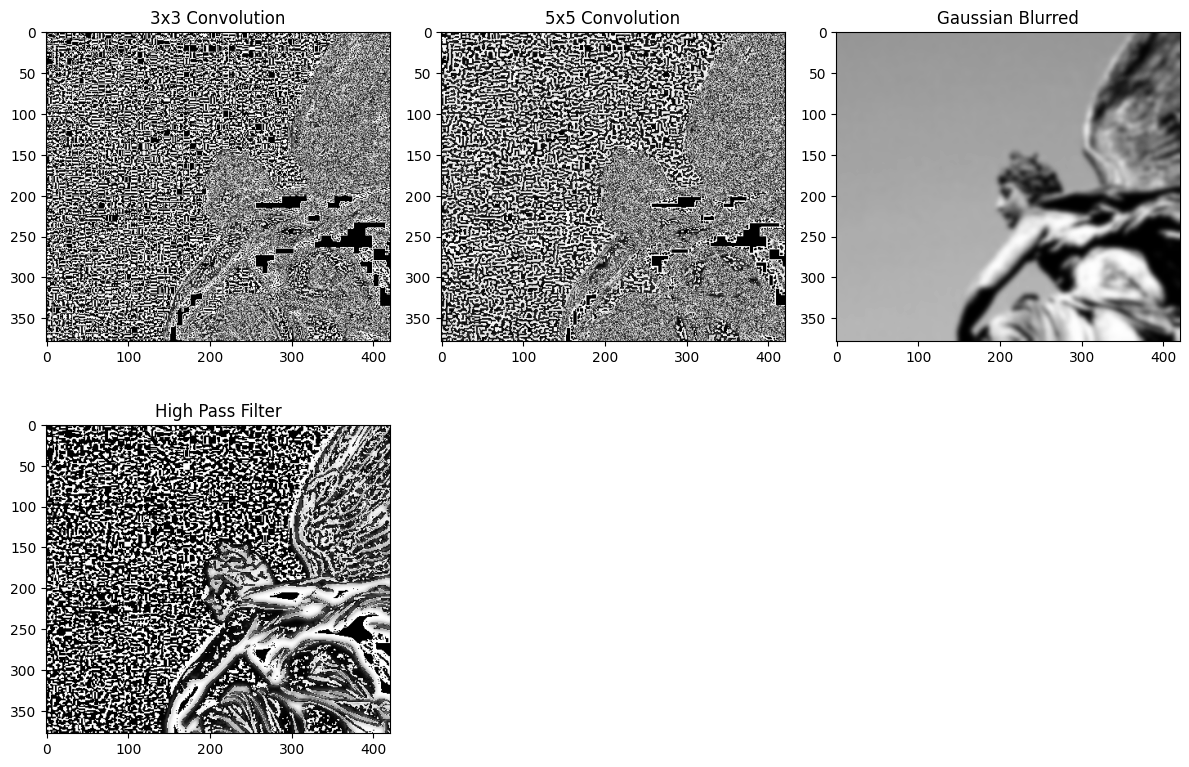

In [5]:
# Import the necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

# Define convolution kernels
kernel_3x3 = np.array([[-1, -1, -1],
                      [-1, 8, -1],
                      [-1, -1, -1]])

kernel_5x5 = np.array([[-1, -1, -1, -1, -1],
                      [-1, 1, 2, 1, -1],
                      [-1, 2, 4, 2, -1],
                      [-1, 1, 2, 1, -1],
                      [-1, -1, -1, -1, -1]])

# Load the image
img = cv2.imread("../images/statue_small.jpg", 0)

# Apply convolutions
k3 = ndimage.convolve(img, kernel_3x3)
k5 = ndimage.convolve(img, kernel_5x5)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(img, (17, 17), 0)

# Calculate the high-pass filter
g_hpf = img - blurred

# Display images using Matplotlib
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(k3, cmap='gray')
plt.title('3x3 Convolution')

plt.subplot(2, 3, 2)
plt.imshow(k5, cmap='gray')
plt.title('5x5 Convolution')

plt.subplot(2, 3, 3)
plt.imshow(blurred, cmap='gray')
plt.title('Gaussian Blurred')

plt.subplot(2, 3, 4)
plt.imshow(g_hpf, cmap='gray')
plt.title('High Pass Filter')

plt.tight_layout()
plt.show()


## Edge detection
Edges play a major role in both human and computer vision. We, as humans, can easily
recognize many object types and their pose just by seeing a backlit silhouette or a rough
sketch. Indeed, when art emphasizes edges and poses, it often seems to convey the idea of
an archetype, such as Rodin's The Thinker or Joe Shuster's Superman. Software, too, can
reason about edges, poses, and archetypes.

OpenCV provides many edge-finding filters, including Laplacian, Sobel, and Scharr.
These filters are supposed to turn non-edge regions into black and turn edge regions into
white or saturated colors. However, they are prone to misidentifying noise as edges. This
flaw can be mitigated by blurring an image before trying to find its edges.

OpenCV also provides many blurring filters, including blur (a simple average), medianBlur, and
GaussianBlur. The arguments for the edge-finding and blurring filters vary but always
include ksize, an odd whole number that represents the width and height (in pixels) of a
filter's kernel.

## Edge detection with Canny
OpenCV offers a handy function called Canny (after the algorithm's inventor, John F.
Canny), which is very popular not only because of its effectiveness, but also because of the
simplicity of its implementation in an OpenCV program since it is a one-liner:




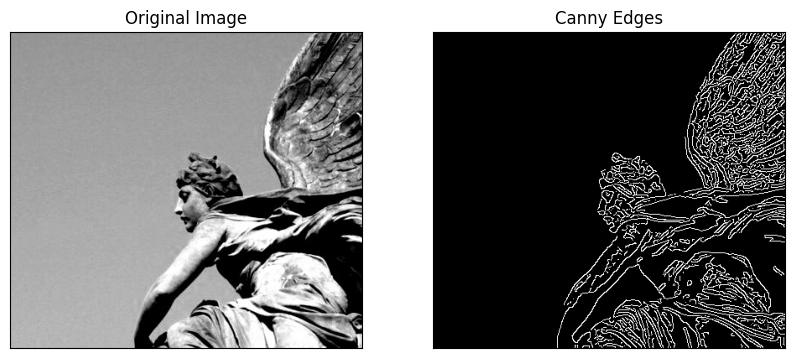

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an image
image = cv2.imread('../images/statue_small.jpg', cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Apply Canny edge detection
edges = cv2.Canny(blurred, threshold1=30, threshold2=70)

# Plot the original image and the edges
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(image, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(edges, cmap='gray')
plt.title('Canny Edges'), plt.xticks([]), plt.yticks([])
plt.show()


The Canny edge detection algorithm is complex but also quite interesting. It is a five-step
process:
1. Denoise the image with a Gaussian filter.
2. Calculate the gradients.
3. Apply non-maximum suppression (NMS) on the edges. Basically, this means that the algorithm selects the best edges from a set of overlapping edges. 
4. Apply a double threshold to all the detected edges to eliminate any false positives.
5. Analyze all the edges and their connection to each other to keep the real edges and discard the weak ones.

After finding Canny edges, we can do further analysis of the edges in order to determine
whether they match a common shape, such as a line or a circle. The Hough transform is one
algorithm that uses Canny edges in this way. 

## Contour detection
A vital task in computer vision is contour detection. We want to detect contours or outlines
of subjects contained in an image or video frame, not only as an end in itself but also as a
step toward other operations. These operations are, namely, computing bounding
polygons, approximating shapes, and generally calculating regions of interest (ROIs).
ROIs considerably simplify interaction with image data because a rectangular region in
NumPy is easily defined with an array slice. We will be using contour detection and ROIs a
lot when we explore the concepts of object detection (including face detection) and object
tracking.


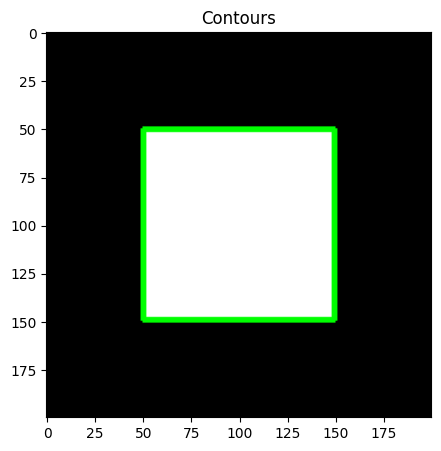

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = np.zeros((200, 200), dtype=np.uint8)
img[50:150, 50:150] = 255
ret, thresh = cv2.threshold(img, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
img_with_contours = cv2.drawContours(color, contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(10, 5))
plt.imshow(img_with_contours)
plt.title("Contours")
plt.show()


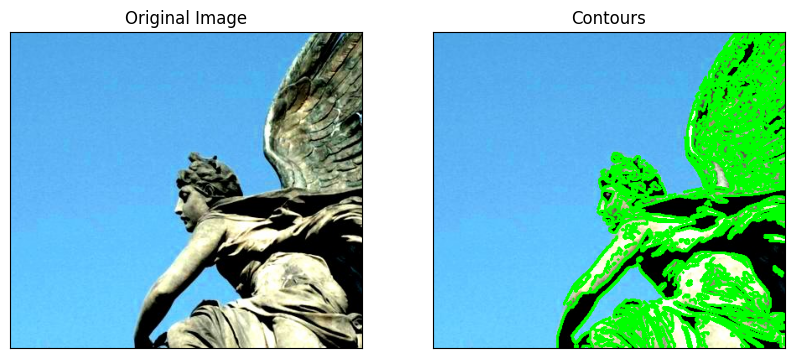

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an image
image = cv2.imread('../images/statue_small.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Perform edge detection (Canny)
edges = cv2.Canny(blurred, threshold1=30, threshold2=70)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on a copy of the original image
contour_image = image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# Plot the original image and the image with contours
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(image[:, :, ::-1])  # Convert BGR to RGB for display
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(contour_image[:, :, ::-1])
plt.title('Contours'), plt.xticks([]), plt.yticks([])
plt.show()


## Bounding box, minimum area rectangle, and minimum enclosing circle
Finding the contours of a square is a simple task; irregular, skewed, and rotated shapes
bring out the full potential of OpenCV's cv2.findContours function. Let's take a look at
the following image:


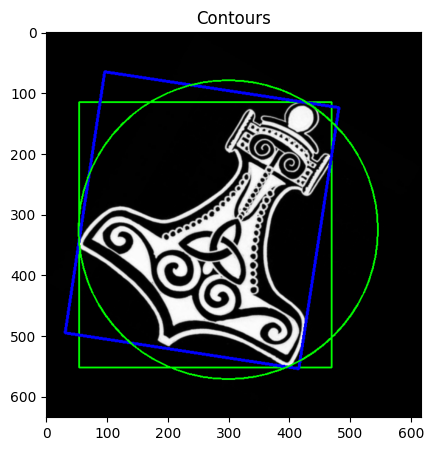

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


img = cv2.pyrDown(cv2.imread("../images/hammer.jpg", cv2.IMREAD_UNCHANGED))
ret, thresh = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_BINARY)
contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for c in contours:
 # find bounding box coordinates
 x,y,w,h = cv2.boundingRect(c)
 cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)
 # find minimum area
 rect = cv2.minAreaRect(c)
 # calculate coordinates of the minimum area rectangle
 box = cv2.boxPoints(rect)
 # normalize coordinates to integers
 box = np.intp(box)
 # draw contours
 cv2.drawContours(img, [box], 0, (0,0, 255), 3)
 # calculate center and radius of minimum enclosing circle
 (x, y), radius = cv2.minEnclosingCircle(c)
 # cast to integers
 center = (int(x), int(y))
 radius = int(radius)
 # draw the circle
 img = cv2.circle(img, center, radius, (0, 255, 0), 2)

plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.title("Contours")
plt.show()

## Convex contours and the Douglas-Peucker algorithm
When working with contours, we may encounter subjects with diverse shapes, including 
convex ones. A convex shape is one where there are no two points within this shape whose
connecting line goes outside the perimeter of the shape itself.
The first facility that OpenCV offers to calculate the approximate bounding polygon of a
shape is cv2.approxPolyDP. This function takes three parameters:
- A contour.
- An epsilon value representing the maximum discrepancy between the original contour and the approximated polygon (the lower the value, the closer the approximated value will be to the original contour).
- A Boolean flag. If it is True, it signifies that the polygon is closed.



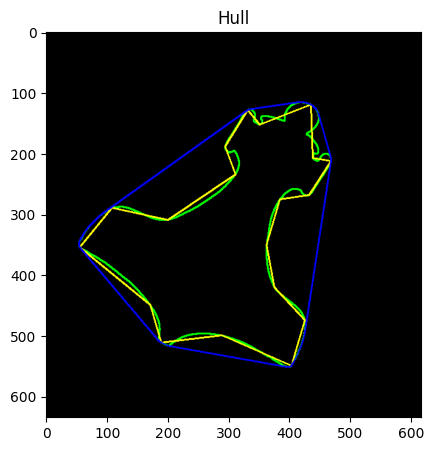

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

OPENCV_MAJOR_VERSION = int(cv2.__version__.split('.')[0])

img = cv2.pyrDown(cv2.imread("../images/hammer.jpg"))

ret, thresh = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
                            127, 255, cv2.THRESH_BINARY)

if OPENCV_MAJOR_VERSION >= 4:
    # OpenCV 4 or a later version is being used.
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL,
                                      cv2.CHAIN_APPROX_SIMPLE)
else:
    # OpenCV 3 or an earlier version is being used.
    # cv2.findContours has an extra return value.
    # The extra return value is the thresholded image, which (in
    # OpenCV 3.1 or an earlier version) may have been modified, but
    # we can ignore it.
    _, contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL,
                                         cv2.CHAIN_APPROX_SIMPLE)

black = np.zeros_like(img)
for cnt in contours:
    epsilon = 0.01 * cv2.arcLength(cnt,True)
    approx = cv2.approxPolyDP(cnt,epsilon,True)
    hull = cv2.convexHull(cnt)
    cv2.drawContours(black, [cnt], -1, (0, 255, 0), 2)
    cv2.drawContours(black, [approx], -1, (255, 255, 0), 2)
    cv2.drawContours(black, [hull], -1, (0, 0, 255), 2)


plt.figure(figsize=(10, 5))
plt.imshow(black)
plt.title("Hull")
plt.show()

## Detecting lines, circles, and other shapes
Detecting edges and finding contours are not only common and important tasks in their
own right; they also form the basis of other complex operations. Line and shape detection
walk hand-in-hand with edge and contour detection, so let's examine how OpenCV
implements these.

The theory behind line and shape detection has its foundation in a technique called the
Hough transform, invented by Richard Duda and Peter Hart, who extended (generalized)
the work that was done by Paul Hough in the early 1960s. Let's take a look at OpenCV's
API for Hough transforms.

### Detecting lines
First of all, let's detect some lines. We can do this with either the HoughLines function or
the HoughLinesP function. The former uses the standard Hough transform, while the latter
uses the probabilistic Hough transform (hence the P in the name). The probabilistic version
is so-called because it only analyzes a subset of the image's points and estimates the
probability that these points all belong to the same line. This implementation is an
optimized version of the standard Hough transform; it is less computationally intensive
and executes faster. HoughLinesP is implemented so that it returns the two endpoints of
each detected line segment, whereas HoughLines is implemented so that it returns a
representation of each line as a single point and an angle, without information about
endpoints.

Let's take a look at a very simple example:

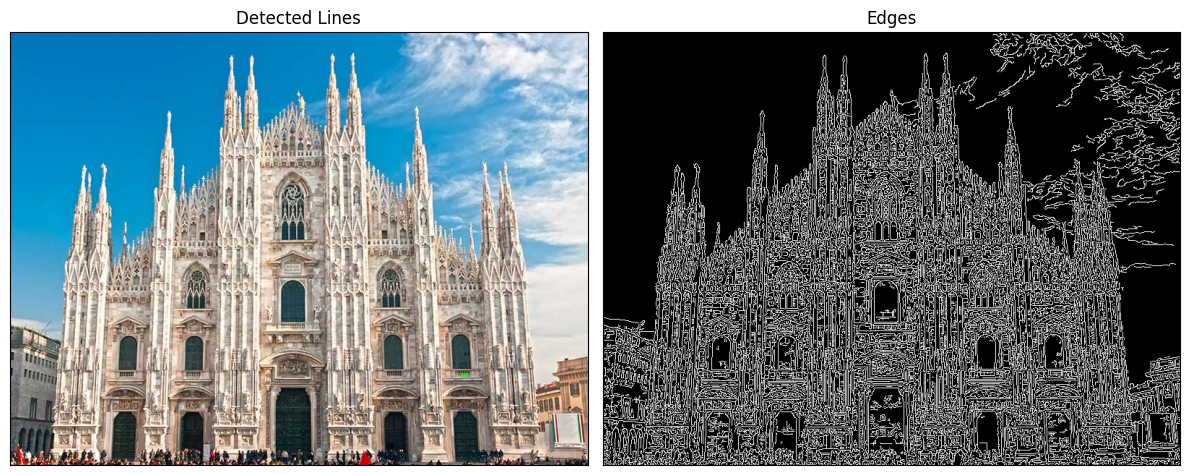

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('../images/lines.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 120)
minLineLength = 20
maxLineGap = 5
lines = cv2.HoughLinesP(edges, 1, np.pi/180.0, 20,
                        minLineLength, maxLineGap)

for x1, y1, x2, y2 in lines[0]:
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Convert BGR to RGB for Matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

# Create subplots to show original image and edges
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(img_rgb)
plt.title("Detected Lines")
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(edges_rgb)
plt.title("Edges")
plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.show()


The crucial part of this simple script – aside from the HoughLines function call – is setting
the minimum line length (shorter lines will be discarded) and the maximum line gap,
which is the maximum size of a gap in a line before the two segments start being
considered as separate lines.

Also, note that the HoughLines function takes a single channel binary image, which is
processed through the Canny edge detection filter. Canny is not a strict requirement, but an
image that has been denoised and only represents edges is the ideal source for a Hough
transform, so you will find this to be a common practice.

The parameters of HoughLinesP are as follows:
- The image.
- The resolution or step size to use when searching for lines. rho is the positional step size in pixels, while theta is the rotational step size in radians. For example, if we specify rho=1 and theta=np.pi/180.0, we search for lines that are separated by as little as 1 pixel and 1 degree.
- The threshold, which represents the threshold below which a line is discarded.
- The Hough transform works with a system of bins and votes, with each bin representing a line, so if a candidate line has at least the threshold number of votes, it is retained; otherwise, it is discarded. 
- minLineLength and maxLineGap, which we mentioned previously.

### Detecting circles
OpenCV also has a function for detecting circles, called HoughCircles. It works in a very
similar fashion to HoughLines, but where minLineLength and maxLineGap were the
parameters to be used to discard or retain lines, HoughCircles has a minimum distance
between a circle's centers, as well as minimum and maximum values for a circle's radius.
Here is the obligatory example:

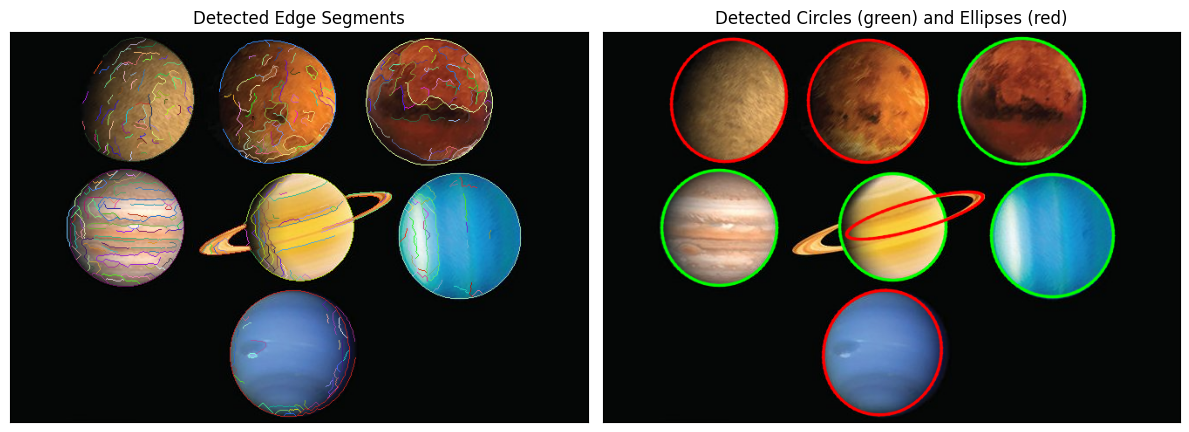

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

planets = cv2.imread("../images/planet_glow.jpg")
gray_img = cv2.cvtColor(planets, cv2.COLOR_BGR2GRAY)
gray_img = cv2.medianBlur(gray_img, 5)

segments_viz = planets.copy()
ellipses_viz = planets.copy()

edge_drawing = cv2.ximgproc.createEdgeDrawing()

# Detect edges and get the resulting edge segments.
edge_drawing.detectEdges(gray_img)
segments = edge_drawing.getSegments()

# Detect circles and ellipses based on the detected edges.
ellipses = edge_drawing.detectEllipses()

# Draw the detected edge segments.
for segment in segments:
    color = (np.random.randint(16, 256),
             np.random.randint(16, 256),
             np.random.randint(16, 256))
    cv2.polylines(segments_viz, [segment], False, color, 1,
                  cv2.LINE_8)

# Draw the detected circles and ellipses.
if ellipses is not None:
    for ellipse in ellipses:
        center = (int(ellipse[0][0]), int(ellipse[0][1]))
        axes = (int(ellipse[0][2] + ellipse[0][3]),
                int(ellipse[0][2] + ellipse[0][4]))
        angle = ellipse[0][5]
        if ellipse[0][2] == 0:  # Ellipse
            color = (0, 0, 255)
        else:  # Circle
            color = (0, 255, 0)
        cv2.ellipse(ellipses_viz, center, axes, angle, 0, 360,
                    color, 2, cv2.LINE_AA)

# Convert BGR to RGB for Matplotlib display
segments_viz_rgb = cv2.cvtColor(segments_viz, cv2.COLOR_BGR2RGB)
ellipses_viz_rgb = cv2.cvtColor(ellipses_viz, cv2.COLOR_BGR2RGB)

# Display the images using Matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(segments_viz_rgb)
plt.title("Detected Edge Segments")
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(ellipses_viz_rgb)
plt.title("Detected Circles (green) and Ellipses (red)")
plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.show()


## Detecting other shapes
OpenCV's implementations of the Hough transform are limited to detecting lines and
circles; however, we already implicitly explored shape detection in general when we talked
about approxPolyDP. This function allows for the approximation of polygons, so if your
image contains polygons, they will be accurately detected through the combined use
of `cv2.findContours` and `cv2.approxPolyDP`